In [2]:
import random
import os
import torch
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import lognorm
import numpy as np
import logging
import sys
from sdo.datasets.sdo_dataset import SDO_Dataset
from torch.utils.data import DataLoader
from sdo.global_vars import DATA_BASEDIR, DATA_INVENTORY
import pandas as pd

notebook_name = '03_MJ_Baseline_for_AutoCal-Experiment2'

np.set_printoptions(precision=3)    

## Loading the data

In [3]:
#just a way to get nice logging messages from the sdo package
logformat = "[%(asctime)s] %(levelname)s:%(name)s:%(message)s"
#logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")
logging.basicConfig(level=logging.WARNING, stream=sys.stdout, format=logformat, datefmt="%Y-%m-%d %H:%M:%S")

In [4]:
subsample = 2
original_ratio = 512
img_shape = int(original_ratio/subsample)
instr = ['AIA','AIA','AIA','AIA','AIA','AIA','AIA','HMI'] #RED FLAG: Insert HMI as the first instrument in the 'instr'.
channels = ['0094','0131','0171','0193','0211','0304','0335','bz']#RED FLAG: Insert HMI as the first channel in the 'channels'.
# instr = ['AIA','AIA','HMI']
# channels = ['0131','0304','bz']

In [5]:
##Loading datasets with the latest SDO_Datset
#data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2012, 2013], #experiment 1
#data = SDO_Dataset(instr=instr, channels=channels, yr_range=[2010, 2011], #experiment 2
data = SDO_Dataset(data_basedir=DATA_BASEDIR,data_inventory=DATA_INVENTORY,
                         instr=instr, channels=channels, yr_range=[2010, 2013], #experiment 2
                         mnt_step=1, day_step=1, h_step=6, min_step=60,
                         subsample=subsample, 
                         normalization=0, scaling=False, test=True)
batch_size = data.__len__()*len(channels) # Loading the number of images = files*channels
loader= DataLoader(data,batch_size=batch_size, shuffle=False) 

In [6]:
#The loop below is used to load the data from the data loader.
for batch_idx, (input_data) in enumerate(loader):
    input_data = input_data.numpy()

## Reference

In [7]:
# N.B- we do not deal with the noise in the channels 94, 335. or any other AIA channel. Important for the paper. 

dimension_input_data = input_data.shape
xposmin=np.int(original_ratio/(4*subsample))
xposmax=np.int(original_ratio/(4*subsample)) + np.int(original_ratio/(2.*subsample))
yposmin=np.int(original_ratio/(4*subsample))
yposmax=np.int(original_ratio/(4*subsample)) + np.int(original_ratio/(2.*subsample))
roi_cut_out=[xposmin,xposmax,yposmin,yposmax] # Avoiding the limb of the Sun.

mag_threshold = 5. # This is the magnetic field strength in Gauss, above which we mask all the pixels with 0 value, rest are 1.

#compute the most probable value for the first image (ground truth) once and iterate over the dimmed. 
mask_qs_reference=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float)
input_cut_out_reference=input_data[0,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]] #Index =0 i.e. time=0
indices_threshold_reference =np.where(np.abs(input_cut_out_reference[7,:,:]) <= mag_threshold)
mask_qs_reference[indices_threshold_reference[0],indices_threshold_reference[1]]=1 # Setting the pixels for the QS to 1

mode_ref = np.zeros([7])
peak_ref=np.zeros([7])

for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:]#.copy #MJ
    indices_no_zero = np.where(quiet_sun_AIA_reference>=0.1) #Considering the pixels without the zeros.
    shape_ref,loc_ref,scale_ref = lognorm.fit(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
    mode_ref[ch] = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref

    test_histo=np.histogram(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]], bins=3000)
    peak_ref[ch]=test_histo[1][np.argmax(test_histo[0])]
    

print("Mode of the fit", mode_ref)
print("Peak of the fit", peak_ref)

Mode of the fit [  1.526  10.176 364.007 369.92   90.108 159.702   5.52 ]
Peak of the fit [  1.674   9.284 450.353 362.466  72.498 140.848   5.563]


0
1
2
3
4
5
6


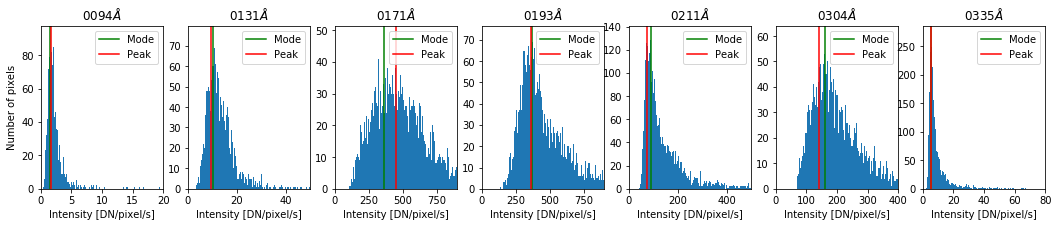

In [8]:
#NO NEED TO RUN
#Just plotting the distributions to check that everything is ok

import pandas as pd
xlimit_plot = [20,50,900,900,500,400,80] #this can be changed for the visualization
# xlimit_plot = [60,700] #this can be changed for the visualization

fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

for ch in range(len(channels)-1): 
    print(ch)
    quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:]#.copy #MJ
    indices_no_zero = np.where(quiet_sun_AIA_reference>=0.1) #Considering the pixels without the zeros.
    ax[0].set_ylabel('Number of pixels');
    ax[ch].set_title(channels[ch]+'$\AA$')
    ax[ch].set_xlabel('Intensity [DN/pixel/s]')
    ax[ch].set_xlim([0,xlimit_plot[ch]])
    ax[ch].hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=3000)  
    ax[ch].axvline(x=mode_ref[ch], color='green',label='Mode')
    ax[ch].axvline(x=peak_ref[ch], color='red',label='Peak')
    ax[ch].legend()
    


# plt.savefig('/home/lguedesd/hist.png',dpi=300,bbox_inches='tight')

5


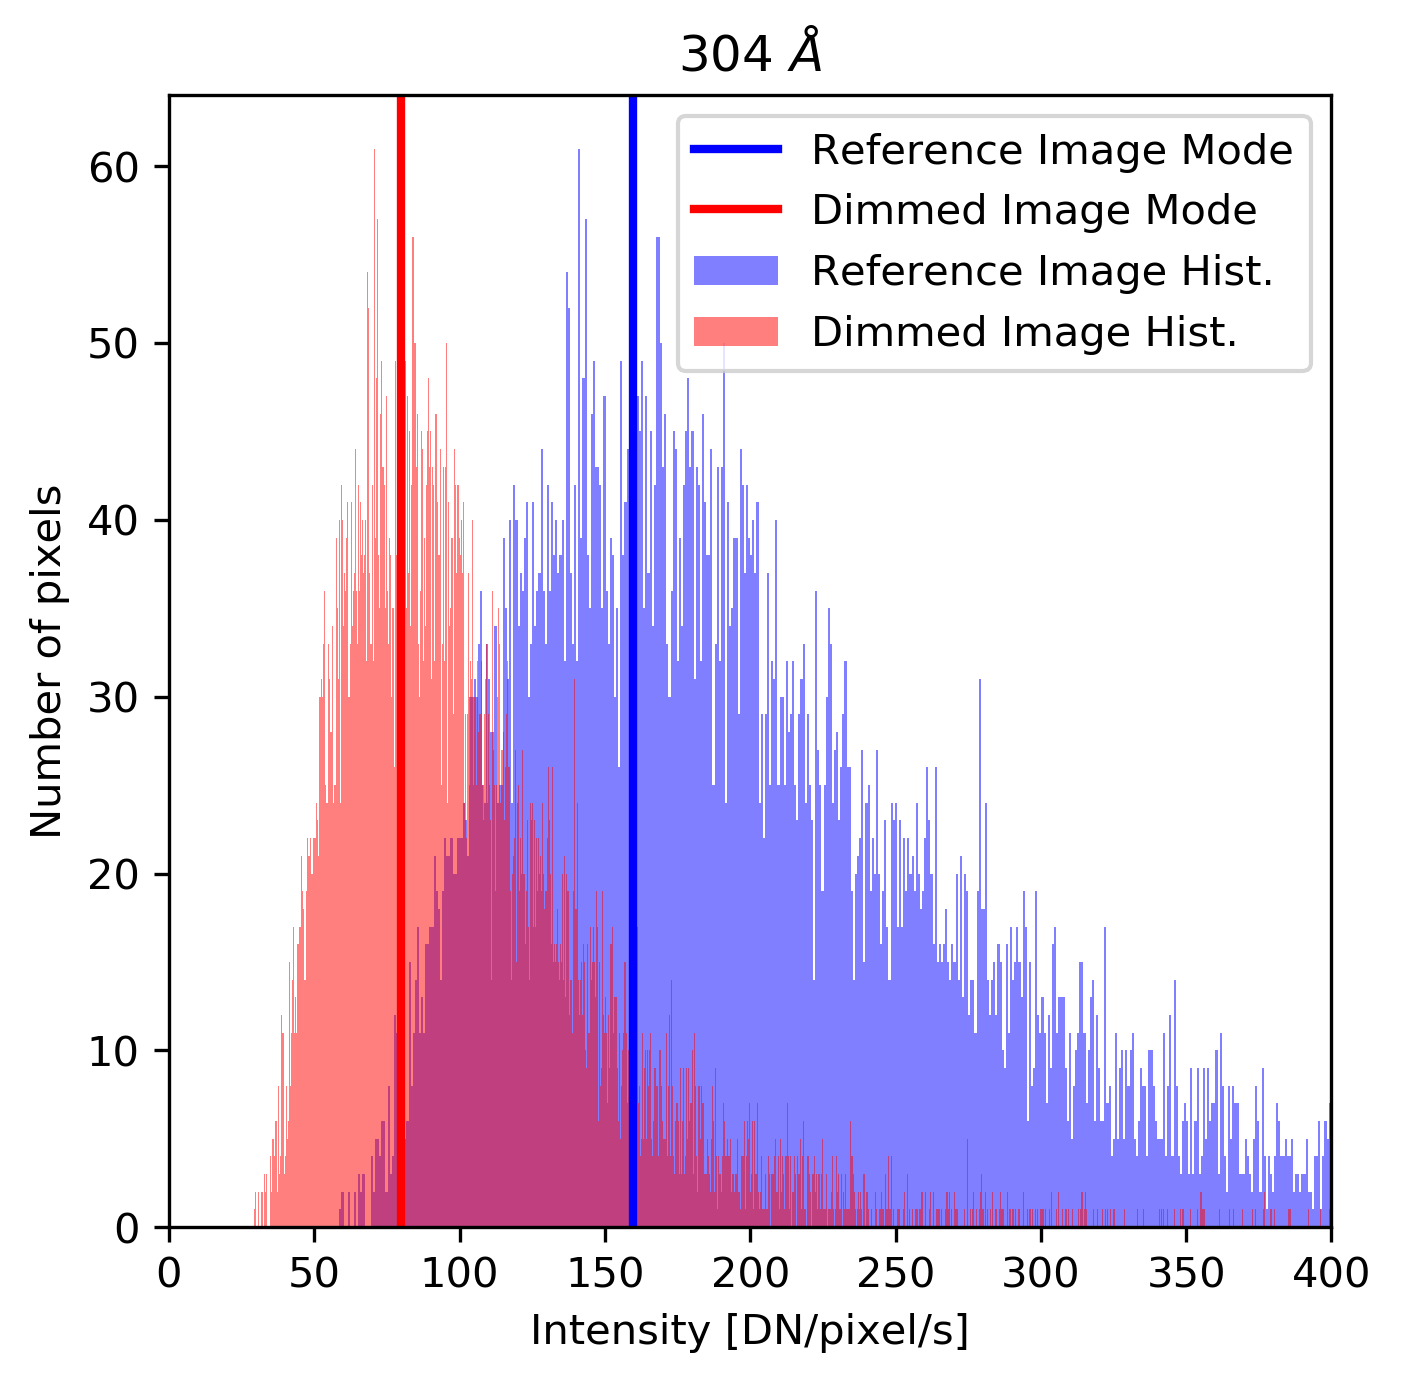

In [29]:
#NO NEED TO RUN. DOING THE PLOT FOR THE 304 CHANNEL IN THE PAPER!!!
#Just plotting the distributions to check that everything is ok
dimmed_sun = quiet_sun_AIA_reference *0.5
ch=5
indices_no_zero = np.where(dimmed_sun>=0.1) #Considering the pixels without the zeros.
shape_ref,loc_ref,scale_ref = lognorm.fit(dimmed_sun[indices_no_zero[0],indices_no_zero[1]],floc=0)# Fitting a log normal distribution 
dimmed_ref = np.exp(np.log(scale_ref)-shape_ref**2)+loc_ref

test_histo=np.histogram(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]], bins=3000)
peak_ref[ch]=test_histo[1][np.argmax(test_histo[0])]

xlimit_plot = [20,50,900,900,500,400,80] #this can be changed for the visualization
# xlimit_plot = [60,700] #this can be changed for the visualization


fig, ax = plt.subplots(figsize=(5,5), sharey=False, dpi=300)

print(ch)
quiet_sun_AIA_reference = mask_qs_reference*input_cut_out_reference[ch,:,:]#.copy #MJ
indices_no_zero = np.where(quiet_sun_AIA_reference>=0.1) #Considering the pixels without the zeros.
ax.set_ylabel('Number of pixels');
ax.set_title('$304~\AA$')
ax.set_xlabel('Intensity [DN/pixel/s]')
ax.set_xlim([0,xlimit_plot[ch]])
ax.hist(x=pd.Series(np.ravel(quiet_sun_AIA_reference[indices_no_zero[0],indices_no_zero[1]])), bins=3000,\
        color='blue',alpha=0.5, label='Reference Image Hist.')  
ax.hist(x=pd.Series(np.ravel(dimmed_sun[indices_no_zero[0],indices_no_zero[1]])), bins=3000,\
        color='red', alpha=0.5, label='Dimmed Image Hist.')  
ax.axvline(x=mode_ref[ch], color='blue',label='Reference Image Mode',linewidth=2)
ax.axvline(x=dimmed_ref, color='red',label='Dimmed Image Mode',linewidth=2)

# ax.axvline(x=peak_ref[ch], color='red',label='Peak')
ax.legend()
fig.savefig('/home/lguedesd/hist_demo.pdf',dpi=1000,bbox_inches='tight')

diff with mode = [0.032 0.002 0.026 0.028 0.009 0.003 0.002]
diff with peak = [0.004 0.005 0.136 0.014 0.038 0.062 0.005]
diff with mode = [0.034 0.013 0.002 0.024 0.004 0.    0.003]
diff with peak = [1.633e-02 1.458e-01 9.091e-03 1.149e-01 1.343e-04 3.652e-02 5.193e-04]
diff with mode = [0.075 0.007 0.126 0.045 0.014 0.    0.024]
diff with peak = [0.001 0.017 0.159 0.074 0.029 0.003 0.119]
diff with mode = [0.032 0.018 0.008 0.054 0.008 0.    0.006]
diff with peak = [0.006 0.029 0.003 0.093 0.01  0.001 0.01 ]
diff with mode = [0.207 0.04  0.164 0.026 0.043 0.001 0.047]
diff with peak = [0.074 0.036 0.136 0.003 0.015 0.004 0.053]


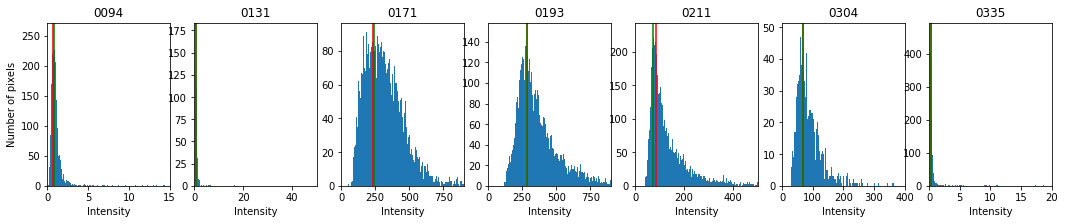

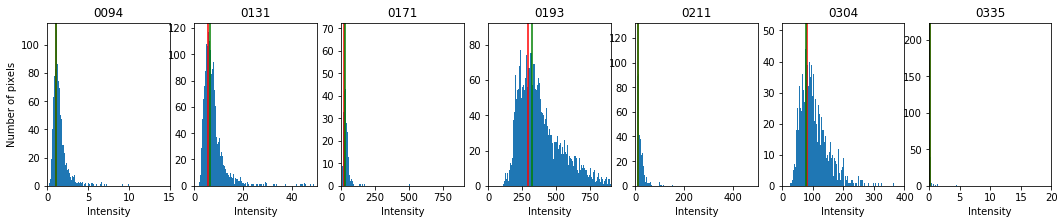

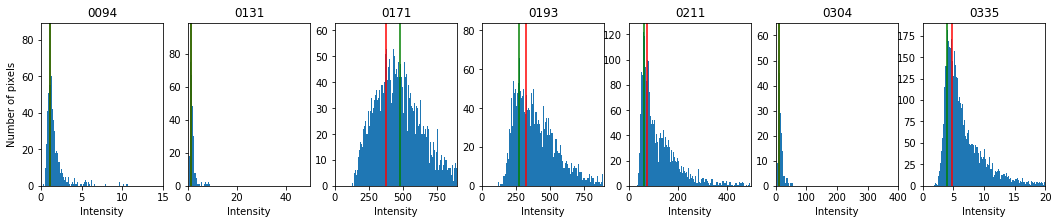

Error in callback <function flush_figures at 0x7f876a12e200> (for post_execute):


KeyboardInterrupt: 

In [25]:
#NO NEED TO RUN
#Checking the results for 10 images and getting some histograms to see whether everything is working fine.


xlimit_plot = [15,50,900,900,500,400,20] #this can be changed for the visualization

alpha_gt = np.zeros([dimension_input_data[0]-1,7])
alpha_pred = np.zeros([dimension_input_data[0]-1,7])
alpha_pred_peak = np.zeros([dimension_input_data[0]-1,7])

mode_dim=np.zeros([7])
peak_dim=np.zeros([7])

nsteps = float(data.__len__())
min_alpha = 0.01
empty_img  = 0

#for index in range(0,dimension_input_data[0]-1): # Iterating over the images throughout the dataset
for index in range(5): # Iterating over the images throughout the dataset
    mask_qs=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float) #This is the mask for the quiet sun. 
    input_cut_out=input_data[index+1,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]]
    indices_threshold =np.where(np.abs(input_cut_out[7,:,:]) <= mag_threshold)
    mask_qs[indices_threshold[0],indices_threshold[1]]=1 # Setting the pixels for the QS to 1
    
    # This is our alpha ground truth.The while loop below ensures that we do not have any value less than min_alpha.
    dim_factor = np.zeros(7)
    while any(dim_factor < min_alpha):
       dim_factor = np.random.rand(7)
    alpha_gt[index,:] = dim_factor

    fig, ax = plt.subplots(1, 7, figsize=(18,3), sharey=False)

    for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.        
        # The same process but now for the artificially dimmed image.
        dim_input_data = dim_factor[ch]*input_cut_out[ch,:,:]
        intensity_mask = dim_input_data*mask_qs>=0.1 
        
        if (intensity_mask).any():
            indices_no_zero_dim = np.where(intensity_mask)
            shape_dim,loc_dim,scale_dim = lognorm.fit(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]],floc=0)
            mode_dim[ch] = np.exp(np.log(scale_dim)-shape_dim**2)+loc_dim
            test_histo=np.histogram(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]], bins=3000)
            peak_dim[ch]=test_histo[1][np.argmax(test_histo[0])]
        
            # Now compute the alpha_predicted
            dim_factor_pred       = mode_dim[ch]/mode_ref[ch]
            alpha_pred[index,ch]  = dim_factor_pred    
            dim_factor_pred_peak  = peak_dim[ch]/peak_ref[ch]
            alpha_pred_peak[index,ch]   = dim_factor_pred_peak
            

        else:
            empty_img +=1
            # discarded images are eliminated from the mean
            alpha_pred[index,ch] = np.nan
            alpha_pred_peak[ch]  = np.nan

        ax[0].set_ylabel('Number of pixels');
        ax[ch].set_title(channels[ch])
        ax[ch].set_xlabel('Intensity')
        ax[ch].set_xlim([0,xlimit_plot[ch]])
        ax[ch].hist(x=pd.Series(np.ravel(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]])), bins=3000)
        ax[ch].axvline(x=mode_dim[ch], color='red')
        ax[ch].axvline(x=peak_dim[ch], color='green')

    print('diff with mode =',np.abs(alpha_pred[index]-alpha_gt[index]))
    print('diff with peak =',np.abs(alpha_pred_peak[index]-alpha_gt[index]))

In [27]:
#Running the previous cell without the histograms, for all the batch.

alpha_gt = np.zeros([dimension_input_data[0]-1,7])
alpha_pred = np.zeros([dimension_input_data[0]-1,7])
alpha_pred_peak = np.zeros([dimension_input_data[0]-1,7])

mode_dim=np.zeros([7])
peak_dim=np.zeros([7])
primary_metric_ch=np.zeros([7])

nsteps = float(data.__len__())
min_alpha = 0.01
tol = 0.05
empty_img  = 0

for index in range(0,dimension_input_data[0]-1): # Iterating over the images throughout the dataset
    mask_qs=np.zeros((np.int(original_ratio/(2.*subsample)),np.int(original_ratio/(2.*subsample))),dtype=float) #This is the mask for the quiet sun. 
    input_cut_out=input_data[index+1,:,roi_cut_out[0]:roi_cut_out[1],roi_cut_out[2]:roi_cut_out[3]]
    indices_threshold =np.where(np.abs(input_cut_out[7,:,:]) <= mag_threshold)
    mask_qs[indices_threshold[0],indices_threshold[1]]=1 # Setting the pixels for the QS to 1
    
    # This is our alpha ground truth.The while loop below ensures that we do not have any value less than min_alpha.
    dim_factor = np.zeros(7)
    while any(dim_factor < min_alpha):
       dim_factor = np.random.rand(7)
    alpha_gt[index,:] = dim_factor

    for ch in range(len(channels)-1): #For each time, iterate over the AIA channels. The last channel is HMI so len(channels)-1.        
        # The same process but now for the artificially dimmed image.
        dim_input_data = dim_factor[ch]*input_cut_out[ch,:,:]
        intensity_mask = dim_input_data*mask_qs>=0.1  #We set this to a low level as 
                                                #some distributions (especially channel 94) have very low pix. intensities
        
        if (intensity_mask).any():
            indices_no_zero_dim = np.where(intensity_mask)
            shape_dim,loc_dim,scale_dim = lognorm.fit(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]],floc=0)
            mode_dim[ch] = np.exp(np.log(scale_dim)-shape_dim**2)+loc_dim
            test_histo=np.histogram(dim_input_data[indices_no_zero_dim[0],indices_no_zero_dim[1]], bins=3000)
            peak_dim[ch]=test_histo[1][np.argmax(test_histo[0])]
        
            # Now compute the alpha_predicted
            dim_factor_pred = mode_dim[ch]/mode_ref[ch]
            alpha_pred[index,ch] = dim_factor_pred    
            dim_factor_pred_peak  = peak_dim[ch]/peak_ref[ch]
            alpha_pred_peak[index,ch]   = dim_factor_pred_peak
 

        else:
            empty_img +=1
            # discarded images are eliminated from the mean
            alpha_pred[index,ch] = np.nan
            alpha_pred_peak[ch]  = np.nan


#     if (index % 10 == 0 and index !=0):
#         print(index)
#         alpha_pred_so_far = alpha_pred[0:index,:]
#         alpha_gt_so_far = alpha_gt[0:index,:]
#         not_null_pred_alpha = alpha_pred_so_far[~np.isnan(alpha_pred_so_far).any(axis=1)]
#         not_null_alpha_gt = alpha_gt_so_far[~np.isnan(alpha_pred_so_far).any(axis=1)]
#         diff  = np.abs(not_null_pred_alpha - not_null_alpha_gt)
#         primary_metric = (diff <= tol).sum() / (diff.shape[0]*diff.shape[1])
#         for ch in range(len(channels)-1):
#             print(ch)
#             primary_metric_ch = (diff[:,ch] <= tol).sum() / (diff.shape[0])
#             print("Mean primary metric so far per channel", primary_metric_ch)
        
#         print("% Progress:", index/nsteps*100)
#         print("Mean primary metric so far", primary_metric)
#         print("Discarded images", empty_img)
        

print('')
print('')
print('Final results over the whole batch')
print('')
print('')

not_null_pred_alpha      = alpha_pred[~np.isnan(alpha_pred).any(axis=1)]
not_null_pred_alpha_peak = alpha_pred_peak[~np.isnan(alpha_pred_peak).any(axis=1)]
not_null_alpha_gt        = alpha_gt[~np.isnan(alpha_pred).any(axis=1)]
not_null_alpha_gt_peak   = alpha_gt[~np.isnan(alpha_pred_peak).any(axis=1)]
diff  = np.abs(not_null_pred_alpha - not_null_alpha_gt)
diff_peak  = np.abs(not_null_pred_alpha_peak - not_null_alpha_gt_peak)
primary_metric = (diff <= tol).sum() / (diff.shape[0]*diff.shape[1])
primary_metric_peak = (diff_peak <= tol).sum() / (diff.shape[0]*diff.shape[1])
for ch in range(len(channels)-1):
#     print(ch)
    five_count = 0
    ten_count = 0
    fifteen_count = 0
    twenty_count = 0
    twenty_five_count = 0
    primary_metric_ch = (diff[:,ch] <= tol).sum() / (diff.shape[0])
    primary_metric_ch_peak = (diff_peak[:,ch] <= tol).sum() / (diff.shape[0])
    for i in range(len(diff[:,ch])-1):
        if (diff[i,ch] <= not_null_alpha_gt[i,ch]*0.05):
            five_count = five_count + 1
        if (diff[i,ch] <= not_null_alpha_gt[i,ch]*0.10):
            ten_count = ten_count + 1
        if (diff[i,ch] <= not_null_alpha_gt[i,ch]*0.15):
            fifteen_count = fifteen_count + 1
        if (diff[i,ch] <= not_null_alpha_gt[i,ch]*0.20):
            twenty_count = twenty_count + 1
        if (diff[i,ch] <= not_null_alpha_gt[i,ch]*0.25):
            twenty_five_count = twenty_five_count + 1         
    five_perc = five_count / (diff.shape[0])
    ten_perc = ten_count / (diff.shape[0])
    fifteen_perc = fifteen_count / (diff.shape[0])
    twenty_perc = twenty_count / (diff.shape[0])
    twenty_five_perc = twenty_five_count / (diff.shape[0])

#     print("Mean primary metric per channel, using mode:", primary_metric_ch)  
#     print("Mean primary metric per channel 5%, using mode:", five_perc)
#     print("Mean primary metric per channel 10%, using mode:", ten_perc)
#     print("Mean primary metric per channel 15%, using mode:", fifteen_perc)
#     print("Mean primary metric per channel 20%, using mode:", twenty_perc)
#     print("Mean primary metric per channel 25%, using mode:", twenty_five_perc)

    print('{:.2f}\% & {:.2f}\% & {:.2f}\% & {:.2f}\% & {:.2f}'.format(primary_metric_ch,five_perc,ten_perc,\
                                                                      fifteen_perc,twenty_perc,twenty_five_perc))


#     print("Mean primary metric per channel, using peak:", primary_metric_ch_peak) 
print()
print("Mean primary metric over all channels, using mode:", primary_metric*100)
print("Mean primary metric over all channels, using peak:", primary_metric_peak*100)
print()
print("Discarded images", empty_img)

print()


np.set_printoptions(precision=3)    
#For Notebook output:
print('Mode')
for ch in range(len(channels)-1):
    five_count = 0
    primary_metric_ch = (diff[:,ch] <= tol).sum() / (diff.shape[0])*100
    for i in range(len(diff[:,ch])-1):
        if (diff[i,ch] <= not_null_alpha_gt[i,ch]*0.05):
            five_count = five_count + 1
    five_perc = five_count / (diff.shape[0])*100

    print('5% - '+str(five_perc))
    print(primary_metric_ch)        
print()
#For Notebook output:
print('Peak')
for ch in range(len(channels)-1):
    primary_metric_ch_peak = (diff_peak[:,ch] <= tol).sum() / (diff.shape[0])*100
    print(primary_metric_ch_peak)        




Final results over the whole batch


0.32\% & 0.08\% & 0.18\% & 0.28\% & 0.40
0.76\% & 0.50\% & 0.73\% & 0.86\% & 0.96
0.58\% & 0.27\% & 0.48\% & 0.66\% & 0.85
0.38\% & 0.13\% & 0.27\% & 0.44\% & 0.53
0.31\% & 0.11\% & 0.21\% & 0.29\% & 0.39
0.86\% & 0.66\% & 0.89\% & 0.95\% & 1.00
0.38\% & 0.13\% & 0.29\% & 0.42\% & 0.51

Mean primary metric over all channels, using mode: 51.218421640956855
Mean primary metric over all channels, using peak: 40.82271406215068

Discarded images 0

Mode
5% - 8.137715179968701
32.3943661971831
5% - 49.76525821596244
76.05633802816901
5% - 27.073552425665103
57.90297339593115
5% - 13.145539906103288
38.341158059467915
5% - 10.641627543035993
30.672926447574334
5% - 65.57120500782473
85.60250391236308
5% - 13.302034428794993
37.558685446009385

Peak
46.478873239436616
48.6697965571205
38.18466353677621
33.48982785602504
18.9358372456964
60.56338028169014
39.436619718309856
